In [1]:
import os
import sys
from datetime import datetime
import keras

import argparse
import numpy as np
import pandas as pd
# import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam, SGD, Adamax

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from model_multitask import build_model
from func import * 

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#### parser
parser = argparse.ArgumentParser()
parser.add_argument('-d' ,'--data', type=str, default='/home/katieyth/gynecology/data/data_cmu_ctu_Ntest.csv', help='data')
parser.add_argument('-s' ,'--model_save', type=str, default='/home/katieyth/gynecology/model_save/', help='model save path')
parser.add_argument('-y' ,'--target', type=str, default='management', help='prediction target')
# variability	UA	 deceleration management

# input parameter
parser.add_argument('-th','--acceptable_zeros_threshold', type=float, default=200, help='acceptable number of missing values in raw data')
parser.add_argument('-l' ,'--length', type=int, default=600, help='length of input')
parser.add_argument('-ks','--k_slice', type=int, default=1, help='a input will be sliced into k_slice segments when testing')
parser.add_argument('-c' ,'--n_channel', type=int, default=2, help='number of input channels')
parser.add_argument('-rn','--random_noise', type=int, default=0, help='add Gaussian noise (mean=0, std=0.01) into inputs')
parser.add_argument('-nm','--normalized', type=int, default=1, help='whether conduct channel-wise normalization')
parser.add_argument('-fb' ,'--force_binary', type=int, default=0, help='force to binary task')
parser.add_argument('-ctu_cmu' ,'--ctu_cmu', type=int, default=1, help='train_ctu_test_cmu')
parser.add_argument('-multi_task' ,'--multi_task', type=int, default=1, help='multi-task')




# data augmentation 
parser.add_argument('-aug_fliplr' ,'--aug_fliplr', type=int, default=0, help='reverse time series')
parser.add_argument('-shift' ,'--DA_Shift', type=int, default=1, help='')
parser.add_argument('-scale' ,'--DA_Scale', type=int, default=1, help='')
parser.add_argument('-randsamp' ,'--DA_RandSampling', type=int, default=1, help='')


# model parameters
parser.add_argument('-k' ,'--kernel_size', type=int, default=3, help='kernel size')
parser.add_argument('-f' ,'--filters', type=int, default=64, help='base number of filters')
parser.add_argument('-ly' ,'--layers', type=int, default=10, help='number of residual layers')
parser.add_argument('-a' ,'--activation', type=str, default='relu', help='activation function')
parser.add_argument('-i' ,'--kernel_initializer', type=str, default='RandomNormal', help='kernel initialization method')
parser.add_argument('-l2','--l2', type=float, default=0.01, help='coefficient of l2 regularization')

# hyper-parameters
parser.add_argument('-lr','--learning_rate', type=float, default=1e-4, help='learning_rate')
parser.add_argument('-reduce_lr_patience','--reduce_lr_patience', type=int, default=5, help='reduce_lr_patience')
parser.add_argument('-bs','--batch_size', type=int, default=16, help='batch_size')
parser.add_argument('-ep','--epoch', type=int, default=2000, help='epoch')
parser.add_argument('-wb','--weight_balance', type=int, default=0, help='whether weight balancing or not')
parser.add_argument('-mntr','--monitor', type=str, default='val_loss', help='val_acc or val_loss')


parser.add_argument('-g' ,'--gpu_id', type=str, default='7', help='GPU ID')
parser.add_argument('-rs' ,'--random_state', type=int, default=13, help='random state when train_test_split')
parser.add_argument('-fn' ,'--summary_file', type=str, default=None, help='summary filename')


FLAG = parser.parse_args([])

In [3]:
def data_preprocess_test(Xvalid, Yvalid, length=600, class_weight = {}):
    
#     if not class_weight:
#         class_weight = dict()
#         for i in range(Yvalid.shape[1]):
#             class_weight[i] = 1

    Xtest = np.empty((Xvalid.shape[0], length, Xvalid.shape[2]))
    Ytest = np.empty((Yvalid.shape[0], Yvalid.shape[1]))
    Wtest = np.empty((Yvalid.shape[0],))

    for i in range(Xvalid.shape[0]):
        # print(st+i)
        Xtest[i,:,:] = data_normalize(Xvalid[i,0:600,:])
        
#         Wtest[i] = class_weight[np.argmax(Yvalid[i,:])]
    Ytest = Yvalid
    return Xtest, Ytest, Wtest

In [4]:
print("===== train =====")
os.environ['CUDA_VISIBLE_DEVICES'] = FLAG.gpu_id
d = pd.read_csv(os.path.join(FLAG.data))
# d = d[myutils.get_n_zeros(np.array(d[[k for k in d.columns if 'b-' in k]], dtype=np.float)) <= FLAG.acceptable_zeros_threshold]

if FLAG.force_binary : 
    d[d[FLAG.target]>1] = 1
n_classes = 4#len(set(d[FLAG.target]))

# replace 0 (no readings) with np.nan for later substitution
for k in d.columns:
    if 'b-' in k or 'm-' in k:
        print(k, end='\r')
        d.loc[d[k]==0, k] = np.nan

if FLAG.ctu_cmu:
    train_d = d[d['ID'].str.contains('CTU_')]
    valid_d = d[d['ID'].str.contains('CMU_')]
else:
    train_d,valid_d = train_test_split(d, test_size=0.3, random_state=FLAG.random_state, stratify =d[FLAG.target])



# interpolate missing values
train_db = np.array(train_d[[k for k in train_d.columns if 'b-' in k]].interpolate(limit_direction='both', axis=1), dtype=np.float)
train_dm = np.array(train_d[[k for k in train_d.columns if 'm-' in k]].interpolate(limit_direction='both', axis=1), dtype=np.float)

valid_db = np.array(valid_d[[k for k in valid_d.columns if 'b-' in k]].interpolate(limit_direction='both', axis=1), dtype=np.float)
valid_dm = np.array(valid_d[[k for k in valid_d.columns if 'm-' in k]].interpolate(limit_direction='both', axis=1), dtype=np.float)

# combine signals from baby and mom
Xtrain = np.stack([train_db, train_dm], axis=2)
Xvalid = np.stack([valid_db, valid_dm], axis=2)

# convert labels to one-hot encodings
if FLAG.multi_task:
    Ytrain_man = keras.utils.to_categorical(np.array(train_d['management']),   num_classes=4)#len(set(np.array(train_d['management']))))
    Ytrain_ua  = keras.utils.to_categorical(np.array(train_d['UA']),           num_classes=4)#len(set(np.array(train_d['UA']))))
    Ytrain_var = keras.utils.to_categorical(np.array(train_d['variability']),  num_classes=4)#len(set(np.array(train_d['variability']))))
    Ytrain_dec = keras.utils.to_categorical(np.array(train_d['deceleration']), num_classes=4)#len(set(np.array(train_d['deceleration']))))
    Ytrain = np.stack([Ytrain_man, Ytrain_ua, Ytrain_var, Ytrain_dec], axis = 2)

    Yvalid_man = keras.utils.to_categorical(np.array(valid_d['management']),   num_classes=4)#len(set(np.array(train_d['management']))))
    Yvalid_ua  = keras.utils.to_categorical(np.array(valid_d['UA']),           num_classes=4)#len(set(np.array(train_d['UA']))))
    Yvalid_var = keras.utils.to_categorical(np.array(valid_d['variability']),  num_classes=4)#len(set(np.array(train_d['variability']))))
    Yvalid_dec = keras.utils.to_categorical(np.array(valid_d['deceleration']), num_classes=4)#len(set(np.array(train_d['deceleration']))))
    Yvalid = np.stack([Yvalid_man, Yvalid_ua, Yvalid_var, Yvalid_dec], axis = 2)
    
else:
    Ytrain = keras.utils.to_categorical(np.array(train_d[FLAG.target]), num_classes=n_classes)
    Yvalid = keras.utils.to_categorical(np.array(valid_d[FLAG.target]), num_classes=n_classes)

# weight balancing or not
# if FLAG.weight_balance:

#     y_integers = np.argmax(Ytrain, axis=1)
#     d_class_weight = compute_class_weight('balanced', np.unique(y_integers), y_integers)
#     class_weight = dict(enumerate(d_class_weight))
#     print('class weight: {0}'.format(class_weight))
# else:
#     class_weight = dict()
#     for i in range(n_classes):
#         class_weight[i] = 1

Xtest, Ytest, Wtest =data_preprocess_test(Xvalid, Yvalid)#, class_weight = class_weight)
#print(Wtest)
# print(Xtest.shape)
# print(Xtest[0:5])
# class weight: {0: 0.5892575039494471, 1: 1.0626780626780628, 2: 2.762962962962963}
# class weight: {0: 0.6411764705882353, 1: 1.09, 2: 1.912280701754386}

===== train =====
b-014

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (8,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
if FLAG.aug_fliplr:
    Xtrain_copy = Xtrain.copy()
    for i in range(len(Xtrain)):
        Xtrain_copy[i] = np.fliplr([Xtrain[i]])[0]
#         plt.plot(Xtrain[i])
#         plt.show()
#         plt.plot(Xtrain_copy[i])
#         plt.show()
        print(i,'/',len(Xtrain), end= '\r')
    Xtrain = np.vstack((Xtrain, Xtrain_copy))
    Ytrain = np.vstack((Ytrain, Ytrain))

In [6]:
augtool = (DA_Shift,DA_Scale,DA_RandSampling)
choose_augtool = (FLAG.DA_Shift,FLAG.DA_Scale,FLAG.DA_RandSampling)
augset = [x for x, y in zip(augtool, choose_augtool) if y == 1]
augset

[<function func.DA_Shift>,
 <function func.DA_Scale>,
 <function func.DA_RandSampling>]

In [7]:
def my_generator(Xtrain, Ytrain, length=300, n_channel=2, n_classes=2, batch_size=16, prob=0.5, aug_func=[], random_noise = False, normalized = True):
    n_sample = Xtrain.shape[0]
    n_length = Xtrain.shape[1]
    ind = list(range(n_sample))
    x = np.empty((batch_size, length, n_channel), dtype=np.float)
    y = np.empty((batch_size, 4,4), dtype=int)

    while True:
        np.random.shuffle(ind)
        for i in range(n_sample//batch_size):
            if length==600:
                st = 0
            else:
                st = random.choice(np.arange(0, Xtrain.shape[1] - length))
            i_batch = ind[i*batch_size:(i+1)*batch_size]
            for j, k in enumerate(i_batch):
                x[j,:] = data_preprocess(Xtrain[k,st:(st+length),:], aug_func=aug_func, prob=prob, random_noise=random_noise, normalized=normalized)
                y[j,:,:] = Ytrain[k,:,:]
            yield x, [y[:,:,0], y[:,:,1], y[:,:,2], y[:,:,3]]

In [8]:
train_gen = my_generator(Xtrain, Ytrain, 
                        length=FLAG.length, 
                        n_channel=FLAG.n_channel, 
                        n_classes=n_classes,
                        random_noise=FLAG.random_noise,
                        normalized=FLAG.normalized,
                        batch_size=FLAG.batch_size,
                        aug_func=augset,
                        prob=0.25)

In [9]:
?model.compile

Object `model.compile` not found.


In [10]:
print("===== create directory =====")
model_id = FLAG.target + "_" + datetime.now().strftime("%y%m%d%H%M%S")
model_save = os.path.join(FLAG.model_save, FLAG.target, model_id)
summary_save = os.path.join(FLAG.model_save, FLAG.target, 'summary_'+FLAG.target+'.csv')

if not os.path.exists(model_save):
    os.makedirs(model_save)
    print(model_save)

# declare model 
model = build_model(length=FLAG.length, n_channel=FLAG.n_channel, n_classes=n_classes, filters=FLAG.filters, kernel_size=FLAG.kernel_size, layers=FLAG.layers,
                activation=FLAG.activation, kernel_initializer=FLAG.kernel_initializer, l_2=FLAG.l2)
model.summary()


lr_rate = FLAG.learning_rate
adam = Adamax(lr_rate, beta_1=0.5, beta_2=0.999, epsilon=1e-08, decay = 0.0)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

csv_logger = keras.callbacks.CSVLogger(os.path.join(model_save, 'training.log'))
checkpoint = keras.callbacks.ModelCheckpoint(os.path.join(model_save, 'model.h5'), 
                                            monitor=FLAG.monitor, 
                                            verbose=1, 
                                            save_best_only=True,
                                            save_weights_only=False,
                                            mode='auto',
                                            period=1)
earlystop = EarlyStopping(monitor = FLAG.monitor, patience=20, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor=FLAG.monitor, factor = 0.5, patience = FLAG.reduce_lr_patience, min_lr = 0, cooldown = 5, verbose = True)


===== create directory =====
/home/katieyth/gynecology/model_save/management/management_181228114837
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 600, 2)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 600, 64)      448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 600, 64)      256         conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 600, 64)      0           batch_normalization_1[0][0]      
________

In [11]:
model.fit_generator(generator=train_gen,
                    #class_weight=class_weight,
                    validation_data=(Xtest, {'man':Ytest[:,:,0],
                                             'ua' :Ytest[:,:,1],
                                             'var':Ytest[:,:,2],
                                             'dec':Ytest[:,:,3]}),#, Wtest),
                    steps_per_epoch=50, 
                    epochs=10, #FLAG.epoch,
                    verbose=1,
                    callbacks=[csv_logger,
                            #reduce_lr, 
                            checkpoint,
                            #earlystop
                              ])


Epoch 1/10
49/50 [============================>.] - ETA: 0s - loss: 51.6684 - man_loss: 1.8436 - dec_loss: 1.9001 - var_loss: 1.2471 - ua_loss: 1.6012 - man_acc: 0.2819 - dec_acc: 0.0702 - var_acc: 0.4401 - ua_acc: 0.1837
Epoch 00001: val_loss improved from inf to 52.12907, saving model to /home/katieyth/gynecology/model_save/management/management_181228114837/model.h5
50/50 [==============================] - 18s 367ms/step - loss: 51.6458 - man_loss: 1.8328 - dec_loss: 1.8961 - var_loss: 1.2454 - ua_loss: 1.5985 - man_acc: 0.2825 - dec_acc: 0.0750 - var_acc: 0.4412 - ua_acc: 0.1850 - val_loss: 52.1291 - val_man_loss: 1.7532 - val_dec_loss: 2.3418 - val_var_loss: 1.0321 - val_ua_loss: 2.1017 - val_man_acc: 0.2077 - val_dec_acc: 0.1691 - val_var_acc: 0.6184 - val_ua_acc: 0.1014
Epoch 2/10
49/50 [============================>.] - ETA: 0s - loss: 50.2117 - man_loss: 1.5771 - dec_loss: 1.5361 - var_loss: 0.9849 - ua_loss: 1.3657 - man_acc: 0.3355 - dec_acc: 0.1875 - var_acc: 0.6684 - ua_ac

In [12]:
def plot_keras_csv_logger(csv_logger, save_dir='', accuracy=False):
    if type(csv_logger) is str:
        loss = pd.read_table(csv_logger, delimiter=',')
    else:
        loss = pd.read_table(csv_logger.filename, delimiter=',')
    print('min val_loss {0} at epoch {1}'.format(min(loss.val_loss), np.argmin(loss.val_loss)))
    plt.plot(loss.epoch, loss.loss, label='loss')
    plt.plot(loss.epoch, loss.val_loss, label='val_loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.savefig(os.path.join(save_dir, 'loss.png'))
    plt.show()
    plt.close()

    if accuracy:
        print('max val_accu {0} at epoch {1}'.format(max(loss.val_dec_acc), np.argmax(loss.val_dec_acc)))
        plt.plot(loss.epoch, loss.dec_acc, label='dec_acc')
        plt.plot(loss.epoch, loss.val_dec_acc, label='val_dec_accu')
        plt.legend()
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.savefig(os.path.join(save_dir, 'dec_acc.png'))
        plt.show()
        plt.close()
        
        print('max val_accu {0} at epoch {1}'.format(max(loss.val_var_acc), np.argmax(loss.val_var_acc)))
        plt.plot(loss.epoch, loss.var_acc, label='var_acc')
        plt.plot(loss.epoch, loss.val_var_acc, label='val_var_accu')
        plt.legend()
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.savefig(os.path.join(save_dir, 'var_acc.png'))
        plt.show()
        plt.close()
        
        print('max val_accu {0} at epoch {1}'.format(max(loss.val_ua_acc), np.argmax(loss.val_ua_acc)))
        plt.plot(loss.epoch, loss.ua_acc, label='ua_acc')
        plt.plot(loss.epoch, loss.val_ua_acc, label='val_ua_accu')
        plt.legend()
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.savefig(os.path.join(save_dir, 'ua_acc.png'))
        plt.show()
        plt.close()
        
        print('max val_accu {0} at epoch {1}'.format(max(loss.val_man_acc), np.argmax(loss.val_man_acc)))
        plt.plot(loss.epoch, loss.dec_acc, label='man_acc')
        plt.plot(loss.epoch, loss.val_dec_acc, label='val_man_accu')
        plt.legend()
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.savefig(os.path.join(save_dir, 'man_acc.png'))
        plt.show()
        plt.close()

min val_loss 48.02577178144225 at epoch 9


/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


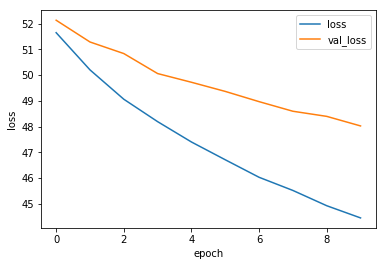

max val_accu 0.17874396207251986 at epoch 2


/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


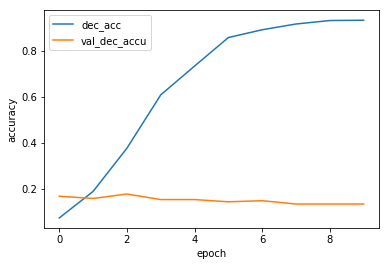

max val_accu 0.8840579713024379 at epoch 8


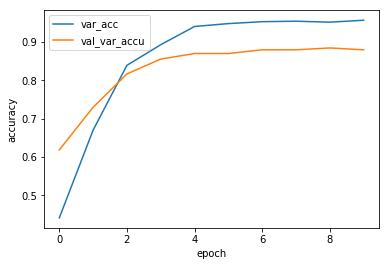

max val_accu 0.1111111111111111 at epoch 1


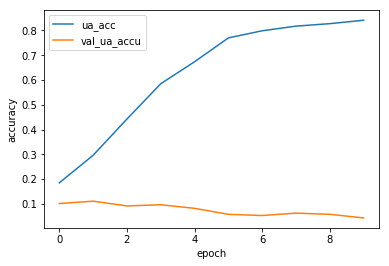

max val_accu 0.6570048323576001 at epoch 8


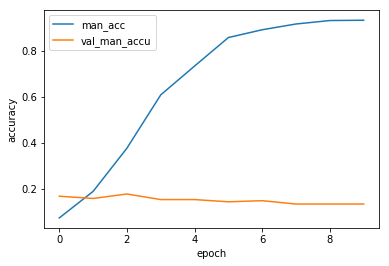

In [13]:
plot_keras_csv_logger(csv_logger, save_dir=model_save, accuracy=True)

In [14]:
path = model_save
print(path)
# path = '/home/katieyth/gynecology/model_save/management/management_181224174216'

/home/katieyth/gynecology/model_save/management/management_181228114837


In [15]:
# evaluate validation set
trained_model = load_model(os.path.join(path,'model.h5'))
Pred = trained_model.predict(Xtest)

In [16]:
# pred_hd_l = np.argmax(Pred, axis=1)
# pred_dataset = valid_d['ID']

In [17]:
# features = trained_model.get_layer('global_average_pooling1d_1')
# extractor = Model(inputs=trained_model.input, outputs=features.output)
# Fout = extractor.predict(x=Xtest)

In [18]:
# O_X = valid_d[FLAG.target] == pred_hd_l
# print(len(O_X)-sum(O_X))
# print(sum(O_X)/len(O_X))
# O_X[O_X==1] = 'gray'
# O_X[O_X==0] = 'red'

In [19]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
# pca_emb = pca.fit_transform(Fout)
# num = len([l for l in valid_d['ID'] if 'CMU_' in l])
# fig = plt.figure(figsize=(15,3))
# plt.subplot('13%s' % (1))
# plt.scatter(pca_emb[:num,0], pca_emb[:num,1], c = valid_d[FLAG.target][:num], marker='o', cmap='coolwarm', alpha=0.4)
# plt.scatter(pca_emb[num:,0], pca_emb[num:,1], c = valid_d[FLAG.target][num:], marker='X', cmap='coolwarm', alpha=0.4)
# plt.ylabel('%s\n PCA (dim=2)' %(FLAG.target), rotation=65)
# plt.title('GT')
# plt.subplot('13%s' % (2))
# plt.scatter(pca_emb[:num,0], pca_emb[:num,1], c = pred_hd_l[:num], marker='o', cmap='coolwarm', alpha=0.4)
# plt.scatter(pca_emb[num:,0], pca_emb[num:,1], c = pred_hd_l[num:], marker='X', cmap='coolwarm', alpha=0.4)
# plt.title('Pred')
# plt.subplot('13%s' % (3))
# plt.scatter(pca_emb[:num,0], pca_emb[:num,1], c = O_X[:num], marker='o', alpha=0.4)
# plt.scatter(pca_emb[num:,0], pca_emb[num:,1], c = O_X[num:], marker='X', alpha=0.4)
# plt.title('Wrong Prediction')
# plt.show()

# check_dir('./plot/feature_analysis/')
# fig.savefig('./plot/feature_analysis/F_analysis_%s.png' % (FLAG.target), dpi=100, format='png',bbox_inches='tight' )

In [22]:
# evaluate by every segment
ypred_aug = np.argmax(Pred , axis=1)
ytest_aug = np.argmax(Ytest, axis=1)

cfm = confusion_matrix(y_pred=ypred_aug, y_true=ytest_aug)
recall = np.diag(cfm) / np.sum(cfm, axis=1)
precision = np.diag(cfm) / np.sum(cfm, axis=0)
val_accu = accuracy_score(y_pred=ypred_aug, y_true=ytest_aug)

print('accuracy : ', val_accu)
for i in range(n_classes):
    print('recall-{0} : {1}'.format(i, recall[i]))
#     print('precision-{0}: {1}'.format(i, precision[i]))
for i in range(n_classes):
#     print('recall-{0} : {1}'.format(i, recall[i]))
    print('precision-{0}: {1}'.format(i, precision[i]))





plt.figure()
rcl = [round(recall[i],2) for i in range(n_classes)]
plot_confusion_matrix(cfm, classes=np.arange(n_classes), title='%s acc: %.2f \nrecall: %s' %(FLAG.target, val_accu,
                                                                                rcl),
                     save_dir=model_save)
# plt.close()
# plt.savefig('./plot/feature_analysis/cfm_%s.png' % (FLAG.target), dpi=100, format='png',bbox_inches='tight' )

ValueError: Found input variables with inconsistent numbers of samples: [207, 4]

In [20]:
# read traing.log
loss = pd.read_table(csv_logger.filename, delimiter=',')
best_val_loss = np.min(loss.val_loss)
best_epoch = np.argmin(loss.val_loss)

/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


In [21]:
# save into dictionary
sav = vars(FLAG)
sav['epoch'] = best_epoch
sav['val_loss'] = best_val_loss
sav['val_dec_acc'] = val_dec_acc

sav['model_id'] = model_id

for i in range(n_classes):
    sav['recall-{0}'.format(i)] = recall[i]
    sav['precision-{0}'.format(i)] = precision[i]

# append into summary files
dnew = pd.DataFrame(sav, index=[0])
if os.path.exists(summary_save):
    dori = pd.read_csv(summary_save)
    dori = pd.concat([dori, dnew])
    dori.to_csv(summary_save, index=False)
else:
    dnew.to_csv(summary_save, index=False)

print(summary_save)

NameError: name 'val_accu' is not defined